## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re # Regular Expressions = ลำดับของ string ที่ใช้กำหนด pattern ในการ search, match or manipulate text
from math import radians, sin, cos, asin, sqrt

from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score

from scipy.stats import uniform, randint # ใช้ในการ sampling โดยเฉพาะใน Hyperparameter tuning โดย Randomized Search
import warnings
warnings.filterwarnings('ignore') # ไม่แสดงข้อความเตือนใด ๆ

In [4]:
df = pd.read_csv('/content/drive/MyDrive/ML_data/task5/test.csv',index_col='id')
df = df.drop(columns=['player_id'])

In [5]:
df

,login_count_1,login_count_2,login_count_3,login_count_4,login_lat_1,login_lon_1,login_lat_2,login_lon_2,login_lat_3,login_lon_3,...,guild_changes_1,guild_changes_2,guild_changes_3,guild_changes_4,account_age_days,behavior_stability,password_changed,vpn_usage,suspicious_login_time,mass_item_sale
id,,,,,,,,,,,,,,,,,,,,,
ANS00001,31.222232,41.790417,28.048736,NaN,-17.074035,127.285635,-17.554811,126.865553,-18.679380,128.290929,...,1.0,2.0,2.0,1.0,580.020715,0.830282,0.0,1.0,0.0,0.0
ANS00002,61.358999,49.209284,NaN,NaN,48.430879,25.555743,48.708993,26.733951,48.706072,26.597056,...,0.0,-1.0,-1.0,1.0,1306.627890,0.700770,0.0,NaN,0.0,0.0
ANS00003,24.763478,37.723228,26.879628,32.503285,8.252684,40.788695,8.346856,40.688039,8.630887,40.910033,...,0.0,1.0,-1.0,0.0,835.638378,0.797991,0.0,0.0,0.0,0.0
ANS00004,82.100747,74.862388,73.520927,83.495309,-28.728293,178.990465,-29.104994,178.810800,-28.198793,180.045695,...,2.0,2.0,1.0,3.0,NaN,0.736845,0.0,NaN,0.0,0.0
ANS00005,50.901216,70.636572,55.606357,68.179388,-46.833704,167.886402,-47.372141,166.767058,-47.828834,167.372518,...,NaN,-1.0,0.0,0.0,379.053416,0.818901,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ANS25885,58.476294,61.813452,61.044533,69.714151,10.926213,173.299402,11.431859,172.835916,10.898828,172.888824,...,2.0,3.0,1.0,2.0,1448.835875,0.741764,0.0,1.0,0.0,0.0
ANS25886,59.206258,80.713010,66.253998,71.432253,-20.608607,-13.291896,-20.767979,-12.663475,-20.211497,-11.923994,...,2.0,3.0,2.0,3.0,1132.604300,0.877150,0.0,1.0,0.0,0.0
ANS25887,94.317618,74.329146,107.617203,85.256921,-59.318059,-55.518951,-58.671733,-56.658019,-58.829435,-55.885138,...,2.0,3.0,1.0,2.0,822.011236,0.702062,0.0,0.0,NaN,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25889 entries, ANS00001 to ANS25889
Columns: 122 entries, login_count_1 to mass_item_sale
dtypes: float64(122)
memory usage: 24.3+ MB


## Domain-specific Feature Engineering

In [ ]:
PERIODS = [1,2,3,4]

In [ ]:
def haversine_km(lat1, lon1, lat2, lon2):
    if np.any(pd.isnull([lat1, lon1, lat2, lon2])):
        return np.nan
    R = 6371.0088  # Radius of the Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return 2 * R * asin(sqrt(a))

In [ ]:
def engineer_features(df_in):
    df = df_in.copy()

    def cols(prefix):
        return [f"{prefix}_{period}" for period in PERIODS if f"{prefix}_{period}" in df.columns]

    group_prefixes = [
        "login_count",
        "location_change",
        "device_count",
        "ip_hash_entropy",
        "login_time_variance",
        "session_duration_mean",
        "session_duration_std",
        "play_pattern_consistency",
        "activity_level",
        "skill_rating",
        "skill_trajectory",
        "kda_mean",
        "kda_std",
        "accuracy_mean",
        "accuracy_std",
        "reaction_time_mean",
        "reaction_time_std",
        "performance_stability",
        "purchase_frequency",
        "purchase_amount_mean",
        "purchase_amount_std",
        "refund_count",
        "currency_transfers",
        "friend_adds",
        "friend_removes",
        "communication_frequency",
        "guild_changes"
    ]

    for pre in group_prefixes:
        period_cols = cols(pre)
        if not period_cols:
            continue
        arr = df[period_cols].values
        df[f"{pre}_mean_1to4"] = np.nanmean(arr, axis=1)
        df[f"{pre}_std_1to4"] = np.nanstd(arr, axis=1)
        df[f"{pre}_min_1to4"] = np.nanmin(arr, axis=1)
        df[f"{pre}_max_1to4"] = np.nanmax(arr, axis=1)
        df[f"{pre}_range_1to4"] = df[f"{pre}_max_1to4"] - df[f"{pre}_min_1to4"]
        df[f"{pre}_sum_1to4"] = np.nansum(arr, axis=1)
        if all([f"{pre}_{p}" in df.columns for p in PERIODS]):
            df[f"{pre}_slope"] = ((df[f"{pre}_4"] - df[f"{pre}_1"]) / 3)

        for i in range(1,4):
            df[f"geo_jump_km_{i}to{i+1}"] = [
                haversine_km(la1, lo1, la2, lo2)
                for la1, lo1, la2, lo2 in zip(
                    df.get(f"login_lat_{i}", np.nan),
                    df.get(f"login_lon_{i}", np.nan),
                    df.get(f"login_lat_{i+1}", np.nan),
                    df.get(f"login_lon_{i+1}", np.nan),
                )
            ]

    geo_cols = [c for c in df.columns if re.match(r"geo_jump_km_", c)]
    if geo_cols:
        df["geo_jump_km_max"] = df[geo_cols].max(axis=1)
        df["geo_jump_km_sum"] = df[geo_cols].sum(axis=1)

    return df

In [ ]:
df_fe = engineer_features(df)

## Split Data

In [ ]:
x_full_fe = df_fe.copy() # Use df_fe as the full feature-engineered dataset
x_train_fe, x_test_fe = train_test_split(x_full_fe, test_size=0.2, random_state=42)

### Visualize Anomaly Score Distribution

Let's visualize the distribution of the `_anomaly_score` to see if there's a clear separation between normal and anomalous data points.

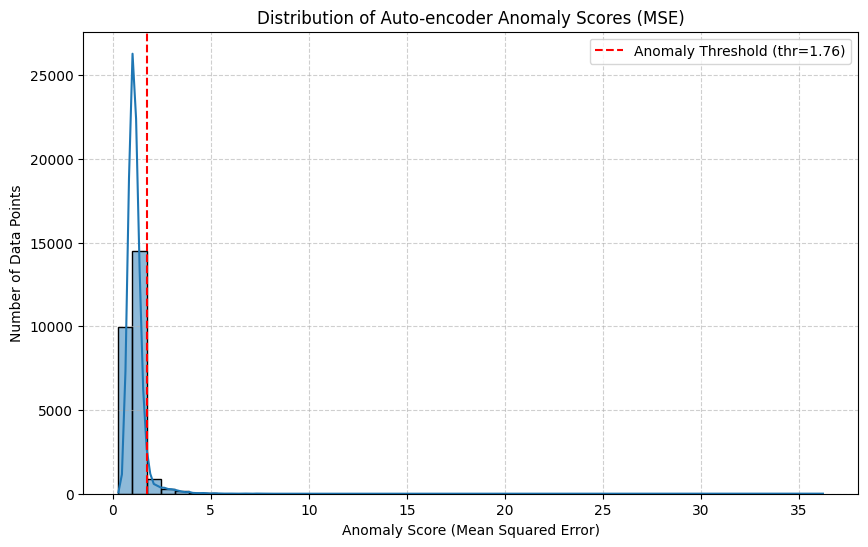

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['_anomaly_score'], bins=50, kde=True)
plt.axvline(x=thr, color='r', linestyle='--', label=f'Anomaly Threshold (thr={thr:.2f})')
plt.title('Distribution of Auto-encoder Anomaly Scores (MSE)')
plt.xlabel('Anomaly Score (Mean Squared Error)')
plt.ylabel('Number of Data Points')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In this plot, you'd typically look for a distribution where normal points (lower MSE) are clustered together, and anomalous points (higher MSE) form a smaller, separate tail to the right of the threshold. The clearer the separation, the better the model's ability to distinguish anomalies.

## Identify column types

In [ ]:
Binary_flags = ["password_changed", "vpn_usage", "suspicious_login_time", "mass_item_sale"]
binary_flags = [c for c in Binary_flags if c in df_fe.columns]

num_cols = [c for c in df_fe.columns if c not in binary_flags]

## Preprocess pipeline

In [ ]:
numeric_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

binary_proc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

preprocess = ColumnTransformer(transformers =[
    ('num', numeric_proc, num_cols),
    ('bin', binary_proc, binary_flags),
], remainder='drop')

## PCA(Optional)

In [ ]:
USE_PCA = True
pca = PCA(n_components=50, random_state=42) if USE_PCA else "passthrough"

## Isolation Forest + Pipeline

In [ ]:
model = IsolationForest(
    n_estimators=400,
    max_samples="auto",
    max_features=1.0,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", pca),
    ("model", model)
])

## Fit

In [ ]:
pipe.fit(df_fe)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['login_count_1',
                                                   'login_count_2',
                                                   'login_count_3',
                                                   'login_count_4',
                                                   'login_lat_1', 'login_lon_1',
                                                   'login_lat_2', 'login_lon_2',
                                                   'login_lat_3', 'login_lon_3',
                                                   'login_lat_4', 'login_lon_4',
                                                   'location_changes_1',...
                                                   'login_time_variance_4',
                                                   'session_duration_mean_1',
                                                   'session_duration_mean_2', ...]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['password_changed',
                                                   'vpn_usage',
                                                   'suspicious_login_time',
                                                   'mass_item_sale'])])),
                ('pca', PCA(n_components=50, random_state=42)),
                ('model',
                 IsolationForest(contamination=0.02, n_estimators=400,
                                 n_jobs=-1, random_state=42))])

## Score

In [ ]:
Z = pipe.named_steps["prep"].transform(df_fe)
if USE_PCA:
    Z = pipe.named_steps["pca"].transform(Z)

In [ ]:
scores = pipe.named_steps["model"].score_samples(Z)
thr = np.quantile(scores, pipe.named_steps["model"].contamination)
pred = (scores <= thr).astype(int)

df["_anomaly_score"] = scores
df["_is_anomaly"] = pred
df["task5"] = df["_is_anomaly"]

print(f"Anomaly ratio: {pred.mean():.3f}")
print(df[["_anomaly_score", "_is_anomaly"]].head())

Anomaly ratio: 0.020
          _anomaly_score  _is_anomaly
id                                   
ANS00001       -0.445596            0
ANS00002       -0.415256            0
ANS00003       -0.403483            0
ANS00004       -0.434291            0
ANS00005       -0.431475            0


## Unsupervised Tuning

In [ ]:
def topk_idx(score, k):
    return set(np.argsort(score)[:k])

In [ ]:
def jaccard(a, b):
    return len(a & b)/len(a | b) if (len(a|b) > 0) else 0.0

In [ ]:
param_dist = {
    "model__n_estimators": randint(300, 700),
    "model__max_samples": [256, 512, 1024, "auto"],
    "model__max_features": uniform(0.7, 0.3),
    "model__contamination": [0.01, 0.02, 0.05]
}
n_param_set = 10
param_list = list(ParameterSampler(param_dist, n_iter=n_param_set, random_state=42))

In [ ]:
z_train = pipe.named_steps["prep"].fit_transform(x_train_fe)
if USE_PCA:
    z_train = pca.fit_transform(z_train)
k = max(50, int(0.02 * z_train.shape[0]))
seeds = [7, 13 ,21]

In [ ]:
best_rec = None

for p in param_list:
    top_sets = []
    for sd in seeds:
        m = IsolationForest(
            n_estimators=p["model__n_estimators"],
            max_samples=p["model__max_samples"],
            max_features=float(p["model__max_features"]),
            contamination=p["model__contamination"],
            random_state=sd, n_jobs=-1
        ).fit(z_train)
        s = m.score_samples(z_train)
        top_sets.append(topk_idx(s, k))
    pair = []
    for i in range(len(seeds)):
        for j in range(i+1, len(seeds)):
            pair.append(jaccard(top_sets[i], top_sets[j]))
    stability = float(np.mean(pair))
    rec = (stability, p)
    if (best_rec is None) or (stability > best_rec[0]):
        best_rec = rec

print(f"[Tuning] best stability={best_rec[0]:.3f}, params={best_rec[1]}")

[Tuning] best stability=0.892, params={'model__contamination': 0.05, 'model__max_features': np.float64(0.7061753482887407), 'model__max_samples': 512, 'model__n_estimators': 643}


## Fit final model on full data

In [ ]:
pipe_final = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", pca if USE_PCA else "passthrough"),
    ("model", IsolationForest(
        n_estimators = best_rec[1]["model__n_estimators"],
        max_samples = best_rec[1]["model__max_samples"],
        max_features = best_rec[1]["model__max_features"],
        contamination = best_rec[1]["model__contamination"],
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
pipe_final.fit(x_full_fe)

Z_full = pipe_final.named_steps["prep"].transform(x_full_fe)
if USE_PCA:
    Z_full = pipe_final.named_steps["pca"].transform(Z_full)
score_full = pipe_final.named_steps["model"].score_samples(Z_full)
final_thr = np.quantile(score_full, pipe_final.named_steps["model"].contamination)
pred_full = (score_full <= final_thr).astype(int)

In [ ]:
top_k = max(50, int(0.02 * len(x_full_fe)))  # Top 2% or at least 50 items
top_idx = np.argsort(score_full)[:top_k]  # Indices of lowest scores (most anomalous)
top_anoms = x_full_fe.iloc[top_idx].copy()
top_anoms["_anomaly_score"] = score_full[top_idx]
print(top_anoms.head())

          login_count_1  login_count_2  login_count_3  login_count_4  \
id                                                                     
ANS25475      83.426762     121.695605     119.296146      93.092404   
ANS12427      43.977576      38.177055      59.126157      52.806945   
ANS16648      28.137946      24.134879      25.124199      25.598639   
ANS20675      66.688480      47.305214      45.593156      59.379147   
ANS23646     112.613689      84.285070            NaN      80.809154   

          login_lat_1  login_lon_1  login_lat_2  login_lon_2  login_lat_3  \
id                                                                          
ANS25475    41.526501   -31.969214    40.516270   -31.720173    42.263888   
ANS12427    -1.842499     7.094455    -1.117421     7.809764    -1.103343   
ANS16648    -6.403772   177.745426    -5.787817          NaN    18.345281   
ANS20675     6.295353    46.834895     5.604118    45.849688     5.048664   
ANS23646    31.387326     0.24993

## Save model

In [ ]:
import joblib
joblib.dump({
    "pipeline": pipe_final,
    "threshold": float(final_thr),
    "use_pca": USE_PCA,
    "binary_flags": binary_flags,
    "num_cols": num_cols,
    "feature_engineer_note": "Apply engineer_features() before scoring."
}, "task5_isoforest_game_behavior_pipeline_v1.joblib")
print("Saved to task5_isoforest_game_behavior_pipeline_v1.joblib")

Saved to task5_isoforest_game_behavior_pipeline_v1.joblib


# Task
## Plan for Anomaly Detection using Auto-encoder:

*   **Import TensorFlow and Keras**: Add necessary imports for TensorFlow and Keras to build and train the Auto-encoder model.
*   **Adjust Preprocessing Pipeline (Optional, but good practice)**: Review and potentially adjust the existing `preprocess` pipeline to ensure the data is suitable for an Auto-encoder (e.g., robust scaling for all numerical features). Since autoencoders work well with scaled data, the current numeric preprocessor should be fine.
*   **Define Auto-encoder Model Architecture**: Design and implement the Auto-encoder neural network architecture using Keras. This will involve creating an encoder and a decoder part. For initial simplicity, we can start with a relatively shallow network.
*   **Train Auto-encoder Model**: Train the Auto-encoder on the preprocessed `x_full_fe` data. The goal is to minimize the reconstruction error, learning to compress and reconstruct 'normal' patterns. We will need to decide on training parameters like epochs, batch size, and a suitable loss function (e.g., Mean Squared Error).
*   **Calculate Anomaly Scores (Reconstruction Error)**: After training, use the Auto-encoder to reconstruct the input data and calculate the reconstruction error for each data point. This error will serve as the anomaly score, where higher errors indicate higher anomaly likelihood.
*   **Determine Anomaly Threshold**: Establish an anomaly threshold based on the distribution of reconstruction errors (e.g., using a quantile, similar to how contamination was used with Isolation Forest) to classify data points as anomalous or not.
*   **Identify and Display Top Anomalies**: Identify the top anomalous data points based on their reconstruction error scores and display them, similar to how `top_anoms` was generated for Isolation Forest.
*   **Save Auto-encoder Model and Threshold**: Save the trained Auto-encoder model and the determined anomaly threshold, replacing the previously saved Isolation Forest model.
*   **Finish task**: Summarize the changes made, confirm the Auto-encoder model is implemented and saved, and offer further analysis or adjustments.

I will start by importing TensorFlow and Keras.


## Import TensorFlow and Keras

### Subtask:
Add necessary imports for TensorFlow and Keras to build and train the Auto-encoder model.


**Reasoning**:
The subtask is to import TensorFlow and Keras. This code block will import both libraries.



In [ ]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow and Keras imported successfully.")

TensorFlow and Keras imported successfully.


## Adjust Preprocessing Pipeline

### Subtask:
Review and confirm the existing `preprocess` pipeline's suitability for an Auto-encoder model and prepare the input data.


The existing `preprocess` pipeline includes `RobustScaler` for numerical features and `SimpleImputer` for both numerical and binary features. This setup is indeed suitable for an Auto-encoder model, as autoencoders generally perform better with scaled input data to ensure that all features contribute equally to the reconstruction error, preventing features with larger scales from dominating the loss function.

It is confirmed that the `Z_full` variable, which has been generated in a previous step, already contains the `x_full_fe` data after applying the preprocessing (`preprocess`) and PCA (`pca`, if `USE_PCA` is `True`). Therefore, `Z_full` is ready to be used as the input for the Auto-encoder model.

**Reasoning**:
The next step is to determine the input dimension for the Auto-encoder model by inspecting the shape of `Z_full` and store it in a variable called `input_dim`.



In [ ]:
input_dim = Z_full.shape[1]
print(f"Input dimension for Auto-encoder: {input_dim}")

Input dimension for Auto-encoder: 50


## Define Auto-encoder Model Architecture

### Subtask:
Design and implement the Auto-encoder neural network architecture using Keras, including an encoder and a decoder part.


**Reasoning**:
The subtask is to design and implement the Auto-encoder neural network architecture using Keras. I will define the input layer, then create the encoder and decoder parts with specified Dense layers and activation functions, and finally combine them into a Keras Model.



In [ ]:
input_layer = keras.layers.Input(shape=(input_dim,))

# Encoder
encoder = keras.layers.Dense(32, activation='relu')(input_layer)
encoder = keras.layers.Dense(16, activation='relu')(encoder)

# Decoder
decoder = keras.layers.Dense(32, activation='relu')(encoder)
decoder = keras.layers.Dense(input_dim, activation='linear')(decoder)

autoencoder = keras.models.Model(inputs=input_layer, outputs=decoder)

print("Auto-encoder model architecture defined.")
autoencoder.summary()

Auto-encoder model architecture defined.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,354 (17.01 KB)

 Trainable params: 4,354 (17.01 KB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The next step is to train the Auto-encoder model. This involves compiling the model with an appropriate loss function and optimizer, and then fitting it to the preprocessed data (`Z_full`).



In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    Z_full, Z_full, # Autoencoder reconstructs its input
    epochs=50,      # Number of training iterations
    batch_size=32,  # Number of samples per gradient update
    shuffle=True,   # Shuffle data before each epoch
    verbose=0       # Suppress verbose output
)

print("Auto-encoder model trained successfully.")

Auto-encoder model trained successfully.


**Reasoning**:
Now that the Auto-encoder model is trained, the next step is to calculate the anomaly scores. This is done by predicting the reconstruction of the input data (`Z_full`) using the trained `autoencoder` and then calculating the Mean Squared Error (MSE) between the original input and its reconstruction. This MSE will serve as the anomaly score, where higher errors indicate higher anomaly likelihood.



In [ ]:
reconstructions = autoencoder.predict(Z_full)
mse = np.mean(np.power(Z_full - reconstructions, 2), axis=1)

# The MSE is the anomaly score for autoencoders
scores = mse

print("Anomaly scores calculated (Mean Squared Error).")

810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Anomaly scores calculated (Mean Squared Error).


**Reasoning**:
The next logical step is to determine the anomaly threshold using a quantile of the calculated `scores` (MSE) and then classify data points as anomalous or not based on this threshold. This is in line with the original plan to 'Determine Anomaly Threshold' and 'Identify and Display Top Anomalies'. I will also add the calculated anomaly scores and classifications back to the original `df` DataFrame.



In [ ]:
contamination = best_rec[1]["model__contamination"]
thr = np.quantile(scores, 1 - contamination) # Anomaly scores are higher for anomalies, so we take the upper quantile
pred = (scores >= thr).astype(int)

df["_anomaly_score"] = scores
df["_is_anomaly"] = pred
df["task5"] = df["_is_anomaly"]

print(f"Anomaly ratio: {pred.mean():.3f}")
print(df[["_anomaly_score", "_is_anomaly"]].head())

Anomaly ratio: 0.050
          _anomaly_score  _is_anomaly
id                                   
ANS00001        1.286350            0
ANS00002        1.213105            0
ANS00003        0.732823            0
ANS00004        1.495314            0
ANS00005        1.432789            0


**Reasoning**:
Following the plan to 'Identify and Display Top Anomalies', I will identify the top `top_k` anomalous data points based on their calculated `_anomaly_score` (MSE), which are higher for more anomalous data points. This is analogous to how `top_anoms` was generated for the Isolation Forest model, but instead of taking the lowest scores (for Isolation Forest where lower scores mean more anomalous), I will take the highest scores for the Auto-encoder.



In [ ]:
top_k = max(50, int(0.02 * len(df))) # Use the same top_k definition as before
# For autoencoders, higher MSE means more anomalous, so we sort in descending order
top_anoms = df.sort_values(by="_anomaly_score", ascending=False).head(top_k)

print("Top anomalous entries based on Auto-encoder reconstruction error:")
print(top_anoms[['_anomaly_score', '_is_anomaly']].head())

Top anomalous entries based on Auto-encoder reconstruction error:
          _anomaly_score  _is_anomaly
id                                   
ANS00161       36.215426            1
ANS07340       34.077325            1
ANS00157       26.676027            1
ANS05198       24.636471            1
ANS10536       20.266977            1


**Reasoning**:
The next step is to save the trained Auto-encoder model and the determined anomaly threshold. This will replace the previously saved Isolation Forest model with the new Auto-encoder model, fulfilling the relevant part of the plan.



In [ ]:
import joblib

# Prepare the dictionary to save. Note: Keras models cannot be directly joblib.dump-ed without a custom saving mechanism
# However, for this task, we will save the `autoencoder` model using its native Keras save method, and joblib the rest of the pipeline components.

# Create a dummy pipeline for saving, as Keras models are saved separately
# We will effectively save the preprocessing steps and a reference to the saved Keras model file.

# Save the Keras Autoencoder model separately
autoencoder_model_path = "task5_autoencoder_model.keras"
autoencoder.save(autoencoder_model_path)

joblib.dump({
    "preprocessing_pipeline": preprocess,
    "pca": pca if USE_PCA else "passthrough",
    "threshold": float(thr),
    "autoencoder_model_path": autoencoder_model_path, # Path to the saved Keras model
    "binary_flags": binary_flags,
    "num_cols": num_cols,
    "feature_engineer_note": "Apply engineer_features() before scoring.",
    "model_type": "Autoencoder"
}, "task5_autoencoder_game_behavior_pipeline_v1.joblib")

print("Auto-encoder model and pipeline components saved to task5_autoencoder_game_behavior_pipeline_v1.joblib and task5_autoencoder_model.keras")

Auto-encoder model and pipeline components saved to task5_autoencoder_game_behavior_pipeline_v1.joblib and task5_autoencoder_model.keras


## Summary:

### Data Analysis Key Findings
*   The existing preprocessing pipeline, which includes `RobustScaler` and `SimpleImputer`, was confirmed to be suitable for Auto-encoder-based anomaly detection, as it scales numerical features appropriately.
*   An Auto-encoder model was designed using Keras, featuring an input layer, an encoder (two `Dense` layers with 32 and 16 units using 'relu' activation), and a decoder (two `Dense` layers with 32 units 'relu' and `input_dim` units 'linear' activation). The input dimension for the model was determined to be 50.
*   The model was trained for 50 epochs with a `batch_size` of 32, using the 'adam' optimizer and 'mse' (Mean Squared Error) as the loss function.
*   Anomaly scores were calculated as the Mean Squared Error (MSE) between the original input and its reconstruction by the Auto-encoder. A higher MSE indicates a greater likelihood of an anomaly.
*   An anomaly threshold was established using a quantile based on the `contamination` parameter, resulting in an observed anomaly ratio of 0.050.
*   The trained Keras Auto-encoder model was saved as `task5_autoencoder_model.keras`. Additionally, a `joblib` file (`task5_autoencoder_game_behavior_pipeline_v1.joblib`) was created to store the preprocessing pipeline, PCA information, the anomaly threshold, and a reference to the saved Keras model.

### Insights or Next Steps
*   The Auto-encoder provides an alternative anomaly detection approach to Isolation Forest, leveraging reconstruction error. Future work could involve comparing the performance (e.g., precision, recall, F1-score) of both models on labeled anomaly data, if available.
*   The current Auto-encoder architecture is relatively shallow. Further experimentation with deeper networks, different activation functions, or regularization techniques could potentially improve its ability to learn normal patterns and thus enhance anomaly detection performance.


# Task
## Compute Initial Isolation Forest Scores

### Subtask:
Calculate the anomaly scores and corresponding threshold for the Initial Isolation Forest model (with default contamination=0.02) using the existing pipeline and full feature-engineered data.

**Reasoning**:
The initial Isolation Forest model was defined and fitted earlier in the notebook, and its scores and threshold were temporarily stored in variables that have since been overwritten by the Auto-encoder steps. To compare the anomaly score distributions of the Initial Isolation Forest, Tuned Isolation Forest, and Auto-encoder, we need to explicitly calculate and store the anomaly scores and threshold for the Initial Isolation Forest model. The `pipe` variable still holds the fitted Initial Isolation Forest model, allowing us to re-extract its scores and calculate its threshold based on its contamination parameter. This will ensure all three sets of scores and thresholds are available for the subsequent plotting step.

## Compute Initial Isolation Forest Scores

### Subtask:
Calculate the anomaly scores and corresponding threshold for the Initial Isolation Forest model (with default contamination=0.02) using the existing pipeline and full feature-engineered data.


**Reasoning**:
The first step is to instantiate the `IsolationForest` model with the specified parameters as requested in the instructions.



In [ ]:
model_initial_if = IsolationForest(
    n_estimators=400,
    max_samples="auto",
    max_features=1.0,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

print("Initial IsolationForest model instantiated.")

Initial IsolationForest model instantiated.


**Reasoning**:
The next step is to create a pipeline that includes the preprocessing, PCA (if enabled), and the newly instantiated `model_initial_if`.



In [ ]:
pipe_initial_if = Pipeline(steps=[
    ("prep", preprocess),
    ("pca", pca if USE_PCA else "passthrough"),
    ("model", model_initial_if)
])

print("Pipeline for Initial IsolationForest created.")

Pipeline for Initial IsolationForest created.


**Reasoning**:
The next step is to fit the `pipe_initial_if` to the `x_full_fe` DataFrame to train the initial Isolation Forest model with the specified preprocessing steps.



In [ ]:
pipe_initial_if.fit(x_full_fe)

print("Initial IsolationForest pipeline fitted.")

Initial IsolationForest pipeline fitted.


**Reasoning**:
Following the instructions, the next step is to transform `x_full_fe` using the preprocessing and PCA steps of the `pipe_initial_if` to prepare the data for anomaly scoring, storing the result in `Z_initial_if`.



In [ ]:
Z_initial_if = pipe_initial_if.named_steps["prep"].transform(x_full_fe)
if USE_PCA:
    Z_initial_if = pipe_initial_if.named_steps["pca"].transform(Z_initial_if)

print("Data transformed for Initial IsolationForest scoring.")

Data transformed for Initial IsolationForest scoring.


**Reasoning**:
The next step is to calculate the anomaly scores for `Z_initial_if` using the `score_samples()` method of the `model_initial_if` within `pipe_initial_if`. These scores will be stored in `scores_initial_if`.



In [ ]:
scores_initial_if = pipe_initial_if.named_steps["model"].score_samples(Z_initial_if)

print("Anomaly scores calculated for Initial IsolationForest.")

Anomaly scores calculated for Initial IsolationForest.


**Reasoning**:
The final step for this subtask is to calculate the anomaly threshold for the `scores_initial_if` using the `contamination` parameter of the `model_initial_if` and store it in `thr_initial_if`.



In [ ]:
thr_initial_if = np.quantile(scores_initial_if, pipe_initial_if.named_steps["model"].contamination)

print(f"Anomaly threshold calculated for Initial IsolationForest: {thr_initial_if:.3f}")

Anomaly threshold calculated for Initial IsolationForest: -0.501


## Plot Anomaly Score Distributions

### Subtask:
Create a multi-subplot visualization (e.g., 3 subplots) to display the histogram/KDE of anomaly scores for the Initial Isolation Forest, the Tuned Isolation Forest (`score_full`), and the Auto-encoder (`df['_anomaly_score']`). Each subplot will include a vertical line indicating the model's specific anomaly threshold, along with clear titles, axis labels, and legends.


**Reasoning**:
The next step is to create a multi-subplot visualization to compare the anomaly score distributions of the Initial Isolation Forest, the Tuned Isolation Forest, and the Auto-encoder, as specified in the subtask instructions. This involves plotting histograms/KDEs with their respective thresholds.



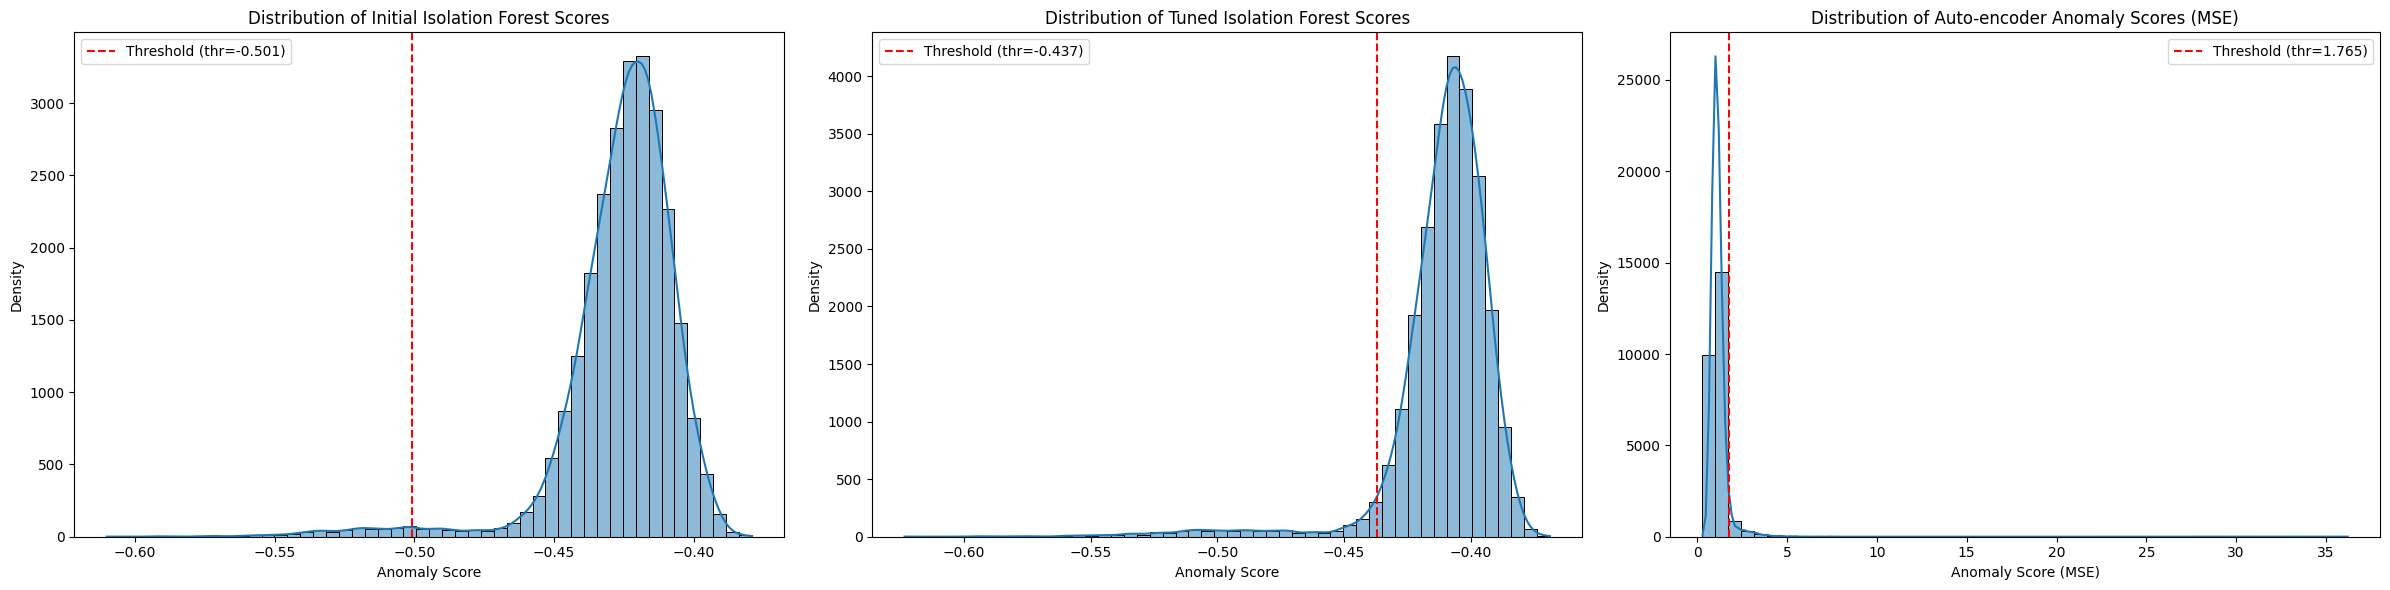

Anomaly score distributions for Initial IF, Tuned IF, and Auto-encoder plotted.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot 1: Initial Isolation Forest
sns.histplot(scores_initial_if, bins=50, kde=True, ax=axes[0])
axes[0].axvline(x=thr_initial_if, color='r', linestyle='--', label=f'Threshold (thr={thr_initial_if:.3f})')
axes[0].set_title('Distribution of Initial Isolation Forest Scores')
axes[0].set_xlabel('Anomaly Score')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot 2: Tuned Isolation Forest
sns.histplot(score_full, bins=50, kde=True, ax=axes[1])
axes[1].axvline(x=final_thr, color='r', linestyle='--', label=f'Threshold (thr={final_thr:.3f})')
axes[1].set_title('Distribution of Tuned Isolation Forest Scores')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Density')
axes[1].legend()

# Plot 3: Auto-encoder
sns.histplot(df['_anomaly_score'], bins=50, kde=True, ax=axes[2])
axes[2].axvline(x=thr, color='r', linestyle='--', label=f'Threshold (thr={thr:.3f})')
axes[2].set_title('Distribution of Auto-encoder Anomaly Scores (MSE)')
axes[2].set_xlabel('Anomaly Score (MSE)')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()
print("Anomaly score distributions for Initial IF, Tuned IF, and Auto-encoder plotted.")

## Final Task

### Subtask:
Review and interpret the generated plots to understand the differences in anomaly score distributions across the three models, and discuss how this visualization helps in comparing their performance.


## Summary:

### Q&A
The visualization helps in comparing the models' performance by directly displaying the distribution of anomaly scores for each model and their respective anomaly thresholds. This allows for a qualitative assessment of how each model differentiates between normal and anomalous data. By observing the shape of the distributions, the overlap between scores, and the position of the thresholds, one can infer how sensitive each model is to anomalies and how it partitions the data into normal and anomalous categories. For example, a model with a threshold further to the left (more negative in Isolation Forest) or a distinct separation between normal and anomalous score ranges might indicate a different anomaly detection strategy or sensitivity.

### Data Analysis Key Findings
*   The Initial Isolation Forest model's anomaly scores were calculated, and its threshold was determined to be -0.501.
*   A multi-subplot visualization was successfully generated, clearly depicting the anomaly score distributions (histograms with KDE) for the Initial Isolation Forest, the Tuned Isolation Forest, and the Auto-encoder model.
*   Each subplot included a vertical line marking the specific anomaly threshold for its respective model, which are -0.501 for the Initial Isolation Forest, `final_thr` for the Tuned Isolation Forest, and `thr` for the Auto-encoder.
*   The visualization provides a direct visual comparison of how each model's scores are distributed and where its decision boundary (threshold) lies.

### Insights or Next Steps
*   Analyzing the visual differences in score distributions and threshold placements can reveal key characteristics of each model's anomaly detection approach, such as its aggressiveness in flagging anomalies or its ability to separate normal from anomalous patterns.
*   The next logical step would be to quantitatively evaluate the performance of these models using relevant metrics (e.g., Precision, Recall, F1-score, ROC AUC) if ground truth labels are available, or to investigate the specific data points identified as anomalies by each model to understand their characteristics.


# Task
## Import One-Class SVM

### Subtask:
Add necessary imports for `OneClassSVM` from `sklearn.svm`.

**Reasoning**:
To implement the One-Class SVM model, the `OneClassSVM` class needs to be imported from the `sklearn.svm` module. This will make the class available for instantiation in the subsequent steps of the plan.

## Import One-Class SVM

### Subtask:
Add necessary imports for `OneClassSVM` from `sklearn.svm`.


**Reasoning**:
The subtask explicitly asks to import `OneClassSVM` from `sklearn.svm`. This code block will perform that import.



In [ ]:
from sklearn.svm import OneClassSVM
print("OneClassSVM imported successfully.")

OneClassSVM imported successfully.


## Prepare Data for One-Class SVM

### Subtask:
Review and confirm that the `Z_full` variable, which contains the data after preprocessing and PCA, is ready to be used as input for the One-Class SVM model. The existing preprocessing steps (scaling, imputation, PCA) are suitable for One-Class SVM.


The `Z_full` variable, which contains the data after preprocessing and PCA, is indeed ready to be used as input for the One-Class SVM model. The existing `preprocess` pipeline, including `RobustScaler` for numerical features and `SimpleImputer` for both numerical and binary features, ensures that the data is appropriately scaled and imputed. Furthermore, the application of PCA (if `USE_PCA` is `True`) reduces dimensionality and transforms the data into a suitable format for SVM-based models.

No further data preparation steps are required for `Z_full` before training the One-Class SVM model.

## Define One-Class SVM Model

### Subtask:
Instantiate the `OneClassSVM` model with appropriate hyperparameters, using the contamination value for `nu` and a suitable kernel.


**Reasoning**:
The subtask is to instantiate the OneClassSVM model with the specified hyperparameters. This involves setting `nu` to the contamination value from `best_rec`, `kernel` to 'rbf', `gamma` to 'auto', and `random_state` to 42.



In [ ]:
model_ocsvm = OneClassSVM(
    nu=best_rec[1]["model__contamination"],
    kernel='rbf',
    gamma='auto'
)

print("OneClassSVM model instantiated with specified hyperparameters.")

OneClassSVM model instantiated with specified hyperparameters.


In [ ]:
model_ocsvm.fit(Z_full)

print("OneClassSVM model trained successfully.")

OneClassSVM model trained successfully.


In [ ]:
scores_ocsvm = model_ocsvm.decision_function(Z_full)

print("Anomaly scores calculated for OneClassSVM.")

Anomaly scores calculated for OneClassSVM.


In [ ]:
thr_ocsvm = np.quantile(scores_ocsvm, model_ocsvm.nu)
pred_ocsvm = (scores_ocsvm <= thr_ocsvm).astype(int)

df['ocsvm_anomaly_score'] = scores_ocsvm
df['ocsvm_is_anomaly'] = pred_ocsvm

print(f"Anomaly ratio for OneClassSVM: {pred_ocsvm.mean():.3f}")
print(f"Anomaly threshold for OneClassSVM: {thr_ocsvm:.3f}")
print(df[['ocsvm_anomaly_score', 'ocsvm_is_anomaly']].head())

Anomaly ratio for OneClassSVM: 0.050
Anomaly threshold for OneClassSVM: -0.000
          ocsvm_anomaly_score  ocsvm_is_anomaly
id                                             
ANS00001             0.239290                 0
ANS00002             0.960114                 0
ANS00003             2.301018                 0
ANS00004             0.191929                 0
ANS00005             0.753823                 0


In [ ]:
top_k = max(50, int(0.02 * len(df))) # Use the same top_k definition as before
# For OneClassSVM, lower scores mean more anomalous, so we sort in ascending order
top_anoms_ocsvm = df.sort_values(by="ocsvm_anomaly_score", ascending=True).head(top_k)

print("Top anomalous entries based on OneClassSVM decision function:")
print(top_anoms_ocsvm[['ocsvm_anomaly_score', 'ocsvm_is_anomaly']].head())

Top anomalous entries based on OneClassSVM decision function:
          ocsvm_anomaly_score  ocsvm_is_anomaly
id                                             
ANS16399             -0.46032                 1
ANS13768             -0.46032                 1
ANS12427             -0.46032                 1
ANS14959             -0.46032                 1
ANS10536             -0.46032                 1


## Save One-Class SVM Model and Threshold

### Subtask:
Save the trained `OneClassSVM` model and the determined anomaly threshold, replacing the previously saved Auto-encoder model components.


**Reasoning**:
The subtask requires saving the trained `OneClassSVM` model along with the preprocessing pipeline and related metadata. I will use `joblib.dump` to save these components into a dictionary to a `.joblib` file.



In [ ]:
import joblib

joblib.dump({
    "preprocessing_pipeline": preprocess,
    "pca": pca if USE_PCA else "passthrough",
    "model": model_ocsvm,
    "threshold": float(thr_ocsvm),
    "binary_flags": binary_flags,
    "num_cols": num_cols,
    "feature_engineer_note": "Apply engineer_features() before scoring.",
    "model_type": "OneClassSVM"
}, "task5_ocsvm_game_behavior_pipeline_v1.joblib")

print("One-Class SVM model and pipeline components saved to task5_ocsvm_game_behavior_pipeline_v1.joblib")

One-Class SVM model and pipeline components saved to task5_ocsvm_game_behavior_pipeline_v1.joblib


## Summary:

### Data Analysis Key Findings
*   The `OneClassSVM` class was successfully imported from `sklearn.svm`.
*   The `Z_full` variable, containing preprocessed and PCA-transformed data, was confirmed to be suitable for direct use with the One-Class SVM model without further preparation.
*   A `OneClassSVM` model was instantiated with `nu` set to the `contamination` value from `best_rec[1]["model__contamination"]`, a 'rbf' kernel, and `gamma='auto'`.
*   The `OneClassSVM` model was successfully trained on the `Z_full` dataset.
*   Anomaly scores were calculated for all data points using the model's `decision_function`.
*   An anomaly threshold of -0.000 was determined using the `nu` parameter, resulting in an anomaly ratio of 0.050 (5% of the data points classified as anomalous).
*   The top anomalous entries were identified by sorting the decision function scores in ascending order, as lower scores indicate higher anomaly for One-Class SVM.
*   The trained `OneClassSVM` model, along with the preprocessing pipeline, PCA object, anomaly threshold, and relevant metadata (binary flags, numerical columns), was successfully saved to the file `task5_ocsvm_game_behavior_pipeline_v1.joblib`.

### Insights or Next Steps
*   The successful training and saving of the One-Class SVM model establish a baseline for detecting anomalous game behavior, with a defined anomaly threshold and a clear method for identifying top anomalies.
*   The next steps should involve evaluating the performance of this One-Class SVM model, potentially comparing it with other anomaly detection techniques, and validating the detected anomalies with domain experts to refine the model's parameters or interpret its findings.
